# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [66]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, isnull, udf, col, to_date, max, min, countDistinct
import pyspark.sql.functions as f
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.cbook as cbook
import numpy as np
import pandas as pd

%matplotlib inline

#set seaborn style
sns.set(style="whitegrid")

In [5]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify churn prediction").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

<ol>
<li>Load data
<li>Review data and identify dirty rows
<li>Drop dirty rows
<li>Check for duplicates
<li>Make time human readable

In [7]:
# Read the sample mini dataset
raw_events_df = spark.read.json('mini_sparkify_event_data.json')

# Review columns
raw_events_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# number of raw events
print('Number of rows in raw dataset: ' + str(raw_events_df.count()))

# There seem to be 2 ID columns: sessionId and userId
raw_events_df.describe("sessionId").show()

raw_events_df.describe("userId").show()

Number of rows in raw dataset: 286500
+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630834|
|    min|                1|
|    max|             2474|
+-------+-----------------+

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910519|
|    min|                  |
|    max|                99|
+-------+------------------+



In [9]:
print('Number of sessions before cleaning: ' + str(raw_events_df.select('sessionId').distinct().count()))
print('Number of users before cleaning: ' + str(raw_events_df.select('userId').distinct().count()))

Number of sessions before cleaning: 2354
Number of users before cleaning: 226


In [10]:
# lets ensure the session and user ID values are valid
raw_events_df.select('userId').where(isnull(raw_events_df.userId)).show()

raw_events_df.select('sessionId').where(isnull(raw_events_df.sessionId)).show()

raw_events_df.groupBy('userId').agg({'userId':'count'}).where(raw_events_df.userId == '') \
    .withColumnRenamed('count(userId)', 'total empty userID rows').show()

raw_events_df.groupBy('sessionId').agg({'sessionId':'count'}).where(raw_events_df.sessionId == '') \
    .withColumnRenamed('count(sessionId)', 'total empty sessionId rows').show()

+------+
|userId|
+------+
+------+

+---------+
|sessionId|
+---------+
+---------+

+------+-----------------------+
|userId|total empty userID rows|
+------+-----------------------+
|      |                   8346|
+------+-----------------------+

+---------+--------------------------+
|sessionId|total empty sessionId rows|
+---------+--------------------------+
+---------+--------------------------+



In [11]:
print('Number of rows without user ID: ' + str(raw_events_df.where(raw_events_df.userId =='').count()))

Number of rows without user ID: 8346


### Remove empty userId

In [12]:
# Removing rows with empty ID field -> in this case its userId
clean_events_df = raw_events_df.where(raw_events_df.userId != '')

In [13]:
print('Number of events after cleaning: ' + str(clean_events_df.count()))
print('Number of sessions after cleaning: ' + str(clean_events_df.select('sessionId').distinct().count()))
print('Number of users after cleaning: ' + str(clean_events_df.select('userId').distinct().count()))

Number of events after cleaning: 278154
Number of sessions after cleaning: 2312
Number of users after cleaning: 225


In [14]:
# check for duplicate rows - looks like there are no duplicates in the dataset
clean_events_df.count() > clean_events_df.dropDuplicates(clean_events_df.schema.names).count()

False

### Format datetime columns

In [15]:
# Finally before EDA, convert time into human readable format
get_time = udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
events = clean_events_df.withColumn('time', get_time(clean_events_df.ts))

In [16]:
events.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-------------------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|               time|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-------------------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 01:01:57|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [17]:
# explore basic characteristics
# define churn by adding churn column(s)
# number of users, artists, songs, pages, timing, gender
# do further EDA

In [18]:
events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)



In [19]:
events.groupBy("page").count().orderBy('count').show()

+--------------------+------+
|                page| count|
+--------------------+------+
|Cancellation Conf...|    52|
|              Cancel|    52|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|               Error|   252|
|       Save Settings|   310|
|               About|   495|
|             Upgrade|   499|
|                Help|  1454|
|            Settings|  1514|
|           Downgrade|  2055|
|         Thumbs Down|  2546|
|              Logout|  3226|
|         Roll Advert|  3933|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|                Home| 10082|
|           Thumbs Up| 12551|
|            NextSong|228108|
+--------------------+------+



#### 1. Auth

In [20]:
events.groupBy('auth').count().orderBy('count').show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [21]:
# taking a look at what 'Cancelled' auth events look like as its the same number as 'Cancellation Confirm' page events
events.filter(events.auth == 'Cancelled').show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|               time|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|2018-10-07 21:26:30|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537

In [22]:
events.filter(events.auth == 'Cancelled').groupBy(['page', 'userId']).count().count() # 52 cancellation events

52

### Get churned users

In [23]:
# Cancelled value in auth column seems to appear with cancellation confirmation
# 2 ways I can define churn
# 1) I can create a lambda function to flag cancellation events with 1 
#    then apply max window over user to get churned users OR
# 2) use the dataframe below to left join 'events' to this 'churned_users' 
#    and keep the count value as churned column

# grouping by page or not yeilds the same set of userIds
churned_users = events.filter(events.auth == 'Cancelled').groupBy(['page', 'userId']).count()

##### Define Churn

In [24]:
# using the first method, we first left join churned users as 'b' with events as 'a' on userId column
# we then select all columns from the left table, i.e. events, and only the count column from right table
# finally we rename count as churned and replace the unmatched rows with 0s into 'events_w_churn'
events_w_churn = events.alias('a').join(churned_users.alias('b'), col('a.userId') == col('b.userId'),  how='left')\
.select([col('a.'+xx) for xx in events.columns] + [col('b.count')])\
.withColumnRenamed('count', 'churned').fillna({'churned': 0})

In [25]:
# events_w_churn.show()

In [26]:
# During EDA, I wanted to go column by column before defining churn 
# but the "auth column" and its unique values led me to define churn
# continuing the exploration we can now look at each column and
# its impact on churn.

#### 2. Registration and times

In [27]:
# Now that we have defined churn and before exploring more columns
# we will now look at what duration of data do we have
#    close together, wide spread, registrations, user lengths etc...

In [28]:
events_w_churn = events_w_churn.withColumn('reg_time', get_time('registration'))

In [29]:
# All our registrations range between 3rd March 2018 to 26th Nov 2018
events_w_churn.groupBy(to_date('reg_time').alias('date')).count().sort('count').select(min("date"), max("date")).show(1)

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-03-18|2018-11-26|
+----------+----------+



In [30]:
# All our events range between 1st Oct 2018 to 3rd Dec 2018
events_w_churn.groupBy(to_date('time').alias('date')).count().sort('count').select(min("date"), max("date")).show(1)

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-10-01|2018-12-03|
+----------+----------+



In [31]:
# Save the data for tableau
# events_w_churn.toPandas().to_csv('clean_events.csv')

In [32]:
daily_events_pd = events_w_churn.groupBy(to_date('time').alias('date')).count().sort('date').toPandas()

[Text(0, 0, '2018-10-01'),
 Text(1, 0, '2018-10-02'),
 Text(2, 0, '2018-10-03'),
 Text(3, 0, '2018-10-04'),
 Text(4, 0, '2018-10-05'),
 Text(5, 0, '2018-10-06'),
 Text(6, 0, '2018-10-07'),
 Text(7, 0, '2018-10-08'),
 Text(8, 0, '2018-10-09'),
 Text(9, 0, '2018-10-10'),
 Text(10, 0, '2018-10-11'),
 Text(11, 0, '2018-10-12'),
 Text(12, 0, '2018-10-13'),
 Text(13, 0, '2018-10-14'),
 Text(14, 0, '2018-10-15'),
 Text(15, 0, '2018-10-16'),
 Text(16, 0, '2018-10-17'),
 Text(17, 0, '2018-10-18'),
 Text(18, 0, '2018-10-19'),
 Text(19, 0, '2018-10-20'),
 Text(20, 0, '2018-10-21'),
 Text(21, 0, '2018-10-22'),
 Text(22, 0, '2018-10-23'),
 Text(23, 0, '2018-10-24'),
 Text(24, 0, '2018-10-25'),
 Text(25, 0, '2018-10-26'),
 Text(26, 0, '2018-10-27'),
 Text(27, 0, '2018-10-28'),
 Text(28, 0, '2018-10-29'),
 Text(29, 0, '2018-10-30'),
 Text(30, 0, '2018-10-31'),
 Text(31, 0, '2018-11-01'),
 Text(32, 0, '2018-11-02'),
 Text(33, 0, '2018-11-03'),
 Text(34, 0, '2018-11-04'),
 Text(35, 0, '2018-11-05'),
 T

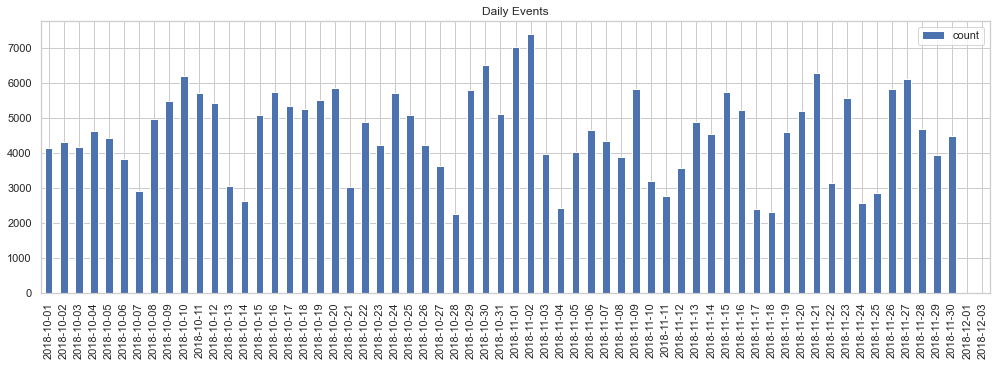

In [33]:
ax = daily_events_pd.plot(kind='bar',figsize=(17,5), title='Daily Events')
ax.set_xticklabels(daily_events_pd['date'].tolist())

In [34]:
events_w_churn.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------+-------------------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|               time|churned|           reg_time|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------+-------------------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"

##### Create days since registration and total days on sparkify columns

In [35]:
# In addition to churned, lets add the lifetime column which will be max event time - reg time for each user

# add days_since_registration column for each event
events_w_churn = events_w_churn.withColumn('days_since_registration',f.round((events_w_churn.ts-events_w_churn.registration)/1000/3600/24))

# create a window over each user
user_window = Window.partitionBy("userId")

# create a column to choose days_since_registration over each window 
events_w_churn = events_w_churn.withColumn('total_days_on_sparkify', f.round(max(events_w_churn.days_since_registration).over(user_window), 0))

In [36]:
events_w_churn.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------+-------------------+-----------------------+----------------------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|               time|churned|           reg_time|days_since_registration|total_days_on_sparkify|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------+-------------------+-----------------------+----------------------+
|Sleeping With Sirens|Logged In| Darianna|     F|   

In [37]:
# We can see that the average time spent on the service for churned users is considerable less
events_w_churn \
    .select('churned','total_days_on_sparkify') \
    .groupBy('churned') \
    .agg({'total_days_on_sparkify':'avg'}).show()

+-------+---------------------------+
|churned|avg(total_days_on_sparkify)|
+-------+---------------------------+
|      0|          93.08523725834797|
|      1|          67.61505884450784|
+-------+---------------------------+



#### gender

<AxesSubplot:xlabel='gender', ylabel='count'>

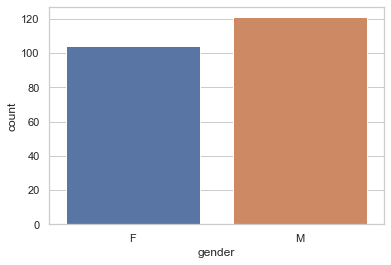

In [38]:
sns.barplot(x='gender',y='count',data=events_w_churn.groupBy('gender').agg(countDistinct('userId').alias('count')).toPandas())

<AxesSubplot:xlabel='churned', ylabel='count'>

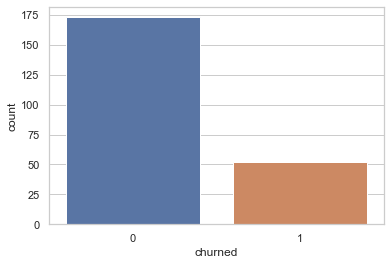

In [39]:
sns.barplot(x='churned', y='count', data = events_w_churn.select('userId', 'churned').groupBy('churned').agg(countDistinct('userId').alias('count')).toPandas())

<AxesSubplot:xlabel='churned', ylabel='count'>

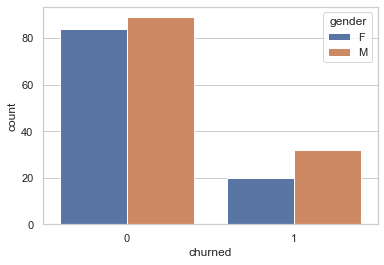

In [40]:
sns.barplot(x='churned', y='count', hue='gender', data=events_w_churn.select('userId', 'churned', 'gender').groupBy('gender', 'churned').agg(countDistinct('userId').alias('count')).toPandas())

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [41]:
events_w_churn.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churned: long (nullable = false)
 |-- reg_time: string (nullable = true)
 |-- days_since_registration: double (nullable = true)
 |-- total_days_on_sparkify: double (nullable = true)



In [42]:
events.groupBy("page").count().orderBy('count').show()

+--------------------+------+
|                page| count|
+--------------------+------+
|Cancellation Conf...|    52|
|              Cancel|    52|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|               Error|   252|
|       Save Settings|   310|
|               About|   495|
|             Upgrade|   499|
|                Help|  1454|
|            Settings|  1514|
|           Downgrade|  2055|
|         Thumbs Down|  2546|
|              Logout|  3226|
|         Roll Advert|  3933|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|                Home| 10082|
|           Thumbs Up| 12551|
|            NextSong|228108|
+--------------------+------+



In [43]:
events_w_churn.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------+-------------------+-----------------------+----------------------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|               time|churned|           reg_time|days_since_registration|total_days_on_sparkify|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------+-------------------+-----------------------+----------------------+
|Sleeping With Sirens|Logged In| Darianna|     F|   

In [44]:
# Feature generation: number of unique pages visited 

events_w_features = events_w_churn.withColumn('total_unique_pages_visited', f.size(f.collect_set('page').over(user_window)))\
                            .withColumn('total_events', f.count('ts').over(user_window)) \
                            .withColumn('total_artists_heard', f.size(f.collect_set('artist').over(user_window))) \
                            .withColumn('total_unique_songs_heard', f.size(f.collect_set('song').over(user_window))) \
                            .withColumn('is_next_song', f.when(events_w_churn.page=='NextSong', 1).otherwise(0))\
                            .withColumn('is_thumbs_up', f.when(events_w_churn.page=='Thumbs Up', 1).otherwise(0)) \
                            .withColumn('is_thumbs_down', f.when(events_w_churn.page=='Thumbs Down', 1).otherwise(0)) \
                            .withColumn('is_settings', f.when(events_w_churn.page=='Settings', 1).otherwise(0)) \
                            .withColumn('is_add_friend', f.when(events_w_churn.page=='Add Friend', 1).otherwise(0))\
                            .withColumn('is_add_to_playlist', f.when(events_w_churn.page=='Add to Playlist',1).otherwise(0))\
                            .withColumn('is_about', f.when(events_w_churn.page=='About',1).otherwise(0))\
                            .withColumn('is_help', f.when(events_w_churn.page=='Help',1).otherwise(0))\
                            .withColumn('is_error', f.when(events_w_churn.page=='Error',1).otherwise(0))

# add average number of songs per session for each user


In [45]:
events_w_features.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churned: long (nullable = false)
 |-- reg_time: string (nullable = true)
 |-- days_since_registration: double (nullable = true)
 |-- total_days_on_sparkify: double (nullable = true)
 |-- total_unique_pages_visited: integer (nullable = false)
 |-- total_events: long

In [46]:
# drop extra columns that are no longer needed or 
# will not be included in this modelling iteration

drop_list = ['artist', 'auth', 'firstName', 
            'itemInSession', 'lastName', 'location',
            'method', 'registration', 'song',
            'status', 'ts', 'userAgent']

events_w_features = events_w_features.drop(*drop_list)

In [47]:
events_w_features = events_w_features.groupBy("userID").agg(
    f.first("churned").alias("label"),
    f.first("gender").alias("gender"),
    f.avg("length").alias("avg_length"),
    f.min("length").alias("min_length"),
    f.max("length").alias("max_length"),
    f.first("level").alias("subscription_level"),
    f.min("time").alias("first_event_time"),
    f.max("time").alias("last_event_time"),
    f.first("reg_time").alias("reg_time"),
    f.first("days_since_registration").alias("days_since_registration"),  
    f.first("total_days_on_sparkify").alias("total_days_on_sparkify"),
    f.first("total_unique_pages_visited").alias("total_unique_pages_visited"),
    f.first("total_events").alias("total_events"),
    f.first("total_artists_heard").alias("total_artists_heard"),
    f.first("total_unique_songs_heard").alias("total_unique_songs_heard"),
    f.sum("is_next_song").alias("total_next_song_events"),
    f.sum("is_thumbs_up").alias("total_thumbs_up_events"),
    f.sum("is_thumbs_down").alias("total_thumbs_down_events"),
    f.sum("is_settings").alias("total_settings_events"),
    f.sum("is_add_friend").alias("total_add_friend_events"),
    f.sum("is_add_to_playlist").alias("total_add_to_playlist_events"),
    f.sum("is_about").alias("total_about_events"),
    f.sum("is_error").alias("total_error_events"),
    f.sum("is_help").alias("total_help_events")
)

In [48]:
df = events_w_features
df = df.withColumn('days_bw_first_last_event', f.datediff('last_event_time', 'first_event_time'))\
        .drop('last_event_time')\
        .drop('first_event_time')\
        .drop('reg_time')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [49]:
df.printSchema()

root
 |-- userID: string (nullable = true)
 |-- label: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- min_length: double (nullable = true)
 |-- max_length: double (nullable = true)
 |-- subscription_level: string (nullable = true)
 |-- days_since_registration: double (nullable = true)
 |-- total_days_on_sparkify: double (nullable = true)
 |-- total_unique_pages_visited: integer (nullable = true)
 |-- total_events: long (nullable = true)
 |-- total_artists_heard: integer (nullable = true)
 |-- total_unique_songs_heard: integer (nullable = true)
 |-- total_next_song_events: long (nullable = true)
 |-- total_thumbs_up_events: long (nullable = true)
 |-- total_thumbs_down_events: long (nullable = true)
 |-- total_settings_events: long (nullable = true)
 |-- total_add_friend_events: long (nullable = true)
 |-- total_add_to_playlist_events: long (nullable = true)
 |-- total_about_events: long (nullable = true)
 |-- total_error_even

In [50]:
categorical_features = ['gender', 'subscription_level']
numerical_features = set(df.columns)-set(categorical_features)

### String Indexing of categorical columns

In [51]:
# convert categorical feature to feature indexes
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(df) for col in categorical_features]

pipeline = Pipeline(stages=indexers)
indexed_df = pipeline.fit(df).transform(df).drop(*categorical_features)

### Vector Assembling of all features

In [52]:
# convert all features into a single vector

input_cols = ['avg_length',
 'min_length',
 'max_length',
 'days_since_registration',
 'total_days_on_sparkify',
 'total_unique_pages_visited',
 'total_events',
 'total_artists_heard',
 'total_unique_songs_heard',
 'total_next_song_events',
 'total_thumbs_up_events',
 'total_thumbs_down_events',
 'total_settings_events',
 'total_add_friend_events',
 'total_add_to_playlist_events',
 'total_about_events',
 'total_error_events',
 'total_help_events',
 'days_bw_first_last_event', 
 'gender_index',
 'subscription_level_index'
]

assembler = VectorAssembler(inputCols= input_cols, outputCol="feature_vector")
indexed_df = assembler.transform(indexed_df).drop(*input_cols)

In [53]:
indexed_df = indexed_df.drop('features')

In [54]:
indexed_df.head()

Row(userID='100010', label=0, feature_vector=DenseVector([243.4214, 52.2706, 538.8534, 11.0, 56.0, 11.0, 381.0, 252.0, 269.0, 275.0, 17.0, 5.0, 0.0, 4.0, 7.0, 1.0, 0.0, 2.0, 44.0, 1.0, 0.0]))

### Scale the features

In [55]:
scaler = StandardScaler(inputCol="feature_vector", outputCol="scaled_feature_vector")
scaled_indexed_df = scaler.fit(indexed_df).transform(indexed_df)

In [56]:
scaled_indexed_df.head()

Row(userID='100010', label=0, feature_vector=DenseVector([243.4214, 52.2706, 538.8534, 11.0, 56.0, 11.0, 381.0, 252.0, 269.0, 275.0, 17.0, 5.0, 0.0, 4.0, 7.0, 1.0, 0.0, 2.0, 44.0, 1.0, 0.0]), scaled_feature_vector=DenseVector([40.9675, 1.4561, 0.7533, 0.3357, 1.4871, 3.336, 0.2866, 0.4173, 0.3001, 0.2489, 0.2596, 0.3823, 0.0, 0.1943, 0.214, 0.3205, 0.0, 0.2761, 2.3162, 2.0013, 0.0]))

In [57]:
scaled_indexed_df = scaled_indexed_df.drop('feature_vector').drop('userID')

### Train model

In [58]:
# split data into train and test
train, test = scaled_indexed_df.randomSplit([0.8,0.2], seed=6)

#### Logistic Regression

In [59]:
lr = LogisticRegression(labelCol='label', featuresCol='scaled_feature_vector',
                        maxIter=10, regParam=0.0)

evaluator = MulticlassClassificationEvaluator(metricName="f1")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train)
cvModel.avgMetrics

[0.8851631063157412, 0.8449030665199191]

#### Random Forest Classifier

In [60]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_feature_vector", numTrees=10)

evaluator_rf = MulticlassClassificationEvaluator(metricName="f1")

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees,[5, 10]) \
    .build()

crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=evaluator_rf,
                          numFolds=3)

cvModel_rf = crossval_rf.fit(train)
cvModel_rf.avgMetrics

[0.8104051224794977, 0.8385750314416927]

#### Gradient Boosted Trees

In [61]:
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_feature_vector", maxDepth=5)

evaluator_gbt = MulticlassClassificationEvaluator(metricName="f1")

paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=evaluator_gbt,
                          numFolds=3)

cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics

[0.8147919627924023, 0.8024057396782098]

In [62]:
rf_final = RandomForestClassifier(labelCol="label", featuresCol="scaled_feature_vector", numTrees=10)

rf_model = rf_final.fit(train)

final_results = rf_model.transform(test)

In [63]:
print(evaluator.evaluate(final_results, {evaluator.metricName: "accuracy"}))

0.7380952380952381


In [64]:
print(evaluator.evaluate(final_results, {evaluator.metricName: "f1"}))

0.7151211361737678


In [91]:
rf_model.featureImportances
# the feature with index 15 has 0 importance which is why its not shown here.

SparseVector(21, {0: 0.0431, 1: 0.0141, 2: 0.0252, 3: 0.0261, 4: 0.1521, 5: 0.2635, 6: 0.0099, 7: 0.0034, 8: 0.0184, 9: 0.0452, 10: 0.0756, 11: 0.0132, 12: 0.052, 13: 0.0217, 14: 0.0284, 16: 0.016, 17: 0.0223, 18: 0.1647, 19: 0.0031, 20: 0.0022})

In [93]:
# removing feature with 0 importance
input_cols.remove('total_about_events')

<AxesSubplot:xlabel='feature_importance', ylabel='columns'>

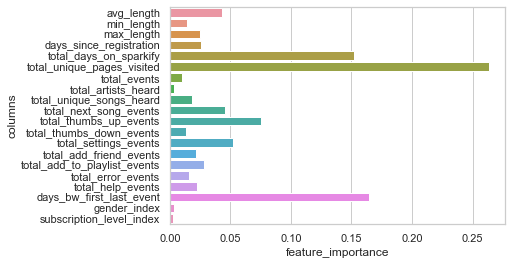

In [94]:
feature_importances = rf_model.featureImportances.values.tolist()
feat_imp_df = pd.DataFrame({'feature_importance': feature_importances, 'columns': input_cols})
sns.barplot(x='feature_importance', y='columns', data=feat_imp_df)

In [ ]:
rf_final = RandomForestClassifier(labelCol="label", featuresCol="scaled_feature_vector", numTrees=10)

rf_model = rf_final.fit(train)

final_results = rf_model.transform(test)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.